# Initial Data EDA

In [4]:
# Load modules
import warnings
warnings.filterwarnings('ignore')
import keras
from keras.layers import Dense
from keras.models import Sequential
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
import os
import sys
sys.path.append('../src/')
# Project modules
import get_modeling_data
import model_evaluation.model_performance_functions as mpf
import features.win_rates as wr
import data_constants as dc
import statsmodels.api as sm
import statsmodels.formula.api as smf

Using TensorFlow backend.


In [5]:
data = pd.read_csv(os.getenv('MINED_DATA_DIR') + 'processed_match_data.csv')
print("Number of rows: " + str(data.shape[0]))
print("Number of columns: " + str(data.shape[1]))
pd.set_option('display.max_columns', 200)
data.head()

Number of rows: 285576
Number of columns: 15


,match_id,game_version,queue_id,game_duration,team_100_win,100_TOP_SOLO,100_JUNGLE_NONE,100_MIDDLE_SOLO,100_BOTTOM_DUO_CARRY,100_BOTTOM_DUO_SUPPORT,200_TOP_SOLO,200_JUNGLE_NONE,200_MIDDLE_SOLO,200_BOTTOM_DUO_CARRY,200_BOTTOM_DUO_SUPPORT
0,2726806213,8.4.218.8787,420,1452,0,Kled,Reng,Kata,Varu,Tari,Akal,Vi,Dr.,Vayn,Lulu
1,2726789592,8.4.218.8787,420,1539,0,Rene,Mast,Fizz,Cait,Lux,Kled,Skar,Kass,Ezre,Sona
2,2726784050,8.4.218.8787,420,1380,0,Kled,Reng,Ryze,Varu,Sora,Gang,Seju,Ahri,Jinx,Blit
3,2726032902,8.4.218.8787,420,1360,1,Kled,Kayn,Fizz,Varu,Tari,Blit,Shac,Kayl,Tris,Lux
4,2726003824,8.4.218.8787,420,1773,1,Kled,Lee,Aniv,Drav,Bard,Yasu,Reng,Ekko,Tris,Tahm


#### Number of Unique Champions

In [3]:
data['100_TOP_SOLO'].nunique()

141

#### Distribution of blue side wins vs. red side wins

In [4]:
data['team_100_win'].value_counts() / data.shape[0]

0    0.505827
1    0.494173
Name: team_100_win, dtype: float64

#### Champions are usually only picked in 1 or 2 positions

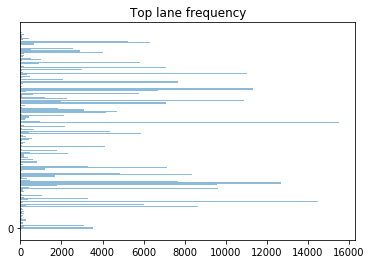

In [30]:
top_lane_freq = data['100_TOP_SOLO'].value_counts()
plt.barh(top_lane_freq.index, top_lane_freq, align='center', alpha=0.5)
plt.title('Top lane frequency')
plt.yticks('')
plt.show()

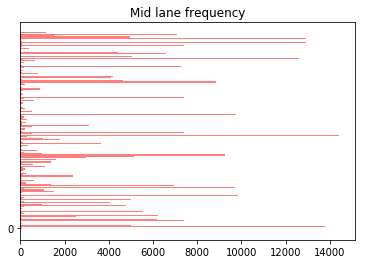

In [31]:
mid_lane_freq = data['100_MIDDLE_SOLO'].value_counts()
plt.barh(mid_lane_freq.index, mid_lane_freq, align='center', alpha=0.5, color='red')
plt.yticks('')
plt.title('Mid lane frequency')
plt.show()

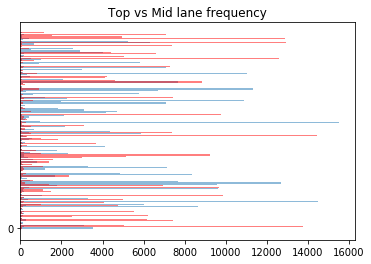

In [32]:
top_lane_freq = data['100_TOP_SOLO'].value_counts()
plt.barh(top_lane_freq.index, top_lane_freq, align='center', alpha=0.5)
mid_lane_freq = data['100_MIDDLE_SOLO'].value_counts()
plt.barh(mid_lane_freq.index, mid_lane_freq, align='center', alpha=0.5, color='red')
plt.title('Top vs Mid lane frequency')
plt.yticks('')
plt.show()

In [7]:
win_rates = pd.read_csv('../data/win_rates/all_champ_all_lanes_win_rates.csv', index_col=0)
win_rates.head()

,TOP_SOLO_win_rate,TOP_SOLO_games_played,MIDDLE_SOLO_win_rate,MIDDLE_SOLO_games_played,BOTTOM_DUO_CARRY_win_rate,BOTTOM_DUO_CARRY_games_played,BOTTOM_DUO_SUPPORT_win_rate,BOTTOM_DUO_SUPPORT_games_played,JUNGLE_NONE_win_rate,JUNGLE_NONE_games_played
Aatr,0.501899,4212.0,0.523364,107.0,0.588235,17.0,0.488372,43.0,0.516491,1425.0
Ahri,0.556818,176.0,0.501790,16479.0,0.480000,100.0,0.535948,153.0,0.571429,7.0
Akal,0.498500,3667.0,0.502720,5882.0,0.250000,16.0,0.580645,31.0,0.537313,268.0
Alis,0.532544,169.0,0.569620,79.0,0.500000,20.0,0.505727,15540.0,0.568421,95.0
Amum,0.543624,149.0,0.611111,36.0,0.500000,2.0,0.435583,163.0,0.502213,6101.0


## 10 Categorical Variables w/ 141 levels each, predicting a 0-1 indicator

In [6]:
# Separate into training, validation, and test
train = get_modeling_data.get_train()
valid = get_modeling_data.get_validation()
train = sm.add_constant(train)
valid = sm.add_constant(valid)

In [ ]:
# Basic Logistic model
#formula = 'team_100_win ~ C(BLUE_TOP_SOLO) + C(BLUE_MIDDLE_SOLO) + C(BLUE_JUNGLE_NONE) + C(BLUE_BOTTOM_DUO_CARRY) + C(BLUE_BOTTOM_DUO_SUPPORT)'
#######################
#### DONT RUN THIS ####
#######################
#basic_logistic = smf.glm(formula=formula, data=train, family=sm.families.Binomial()).fit()

### Lesson 0: GLM won't take variables with leading numbers in the name
### Lesson 1: GLM hot encodes categorical variables, blows up the memory requirement.

# Let's try a basic encoding
### - Replacing champions in each lane with their respective win rate
### - Basic logistic model

In [13]:
lane_cols = ['100_TOP_SOLO', '100_MIDDLE_SOLO', '100_JUNGLE_NONE', '100_BOTTOM_DUO_CARRY',
 '100_BOTTOM_DUO_SUPPORT', '200_TOP_SOLO', '200_MIDDLE_SOLO', '200_JUNGLE_NONE',
 '200_BOTTOM_DUO_CARRY', '200_BOTTOM_DUO_SUPPORT']

lane_cols_color = ['BLUE_TOP_SOLO', 'BLUE_MIDDLE_SOLO', 'BLUE_JUNGLE_NONE', 'BLUE_BOTTOM_DUO_CARRY',
 'BLUE_BOTTOM_DUO_SUPPORT', 'RED_TOP_SOLO', 'RED_MIDDLE_SOLO', 'RED_JUNGLE_NONE',
 'RED_BOTTOM_DUO_CARRY', 'RED_BOTTOM_DUO_SUPPORT']

lane_cols = [x + '_wr' for x in lane_cols]
lane_cols_color = [x + '_wr' for x in lane_cols_color]

lane_cols_dict = dict(zip(lane_cols, lane_cols_color))

train_wr = train.rename(lane_cols_dict, axis=1)
train_wr = train_wr[lane_cols_color + ['team_100_win']]
valid_wr = valid.rename(lane_cols_dict, axis=1)
valid_wr = valid_wr[lane_cols_color + ['team_100_win']]

In [14]:
# Basic Logistic model
wr_formula = 'team_100_win ~ ' +  ' + '.join(lane_cols_color)
basic_logistic = smf.glm(formula=wr_formula, data=train_wr, family=sm.families.Binomial()).fit()
basic_logistic.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:           team_100_win   No. Observations:               171284
Model:                            GLM   Df Residuals:                   171273
Model Family:                Binomial   Df Model:                           10
Link Function:                  logit   Scale:                             1.0
Method:                          IRLS   Log-Likelihood:            -1.1833e+05
Date:                Wed, 08 Aug 2018   Deviance:                   2.3666e+05
Time:                        20:13:29   Pearson chi2:                 1.71e+05
No. Iterations:                     4                                         
==============================================================================================
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept                     20.8230      0.799     26.057      0.000      19.257      22.389
BLUE_TOP_SOLO_wr              -3.2932      0.449     -7.330      0.000      -4.174      -2.413
BLUE_MIDDLE_SOLO_wr           -4.6459      0.463    -10.032      0.000      -5.554      -3.738
BLUE_JUNGLE_NONE_wr           -4.3828      0.546     -8.032      0.000      -5.452      -3.313
BLUE_BOTTOM_DUO_CARRY_wr      -4.9691      0.549     -9.048      0.000      -6.046      -3.893
BLUE_BOTTOM_DUO_SUPPORT_wr    -5.6689      0.464    -12.226      0.000      -6.578      -4.760
RED_TOP_SOLO_wr               -4.8969      0.465    -10.541      0.000      -5.807      -3.986
RED_MIDDLE_SOLO_wr            -3.5145      0.469     -7.498      0.000      -4.433      -2.596
RED_JUNGLE_NONE_wr            -3.8803      0.547     -7.090      0.000      -4.953      -2.808
RED_BOTTOM_DUO_CARRY_wr       -3.5112      0.538     -6.529      0.000      -4.565      -2.457
RED_BOTTOM_DUO_SUPPORT_wr     -2.4565      0.457     -5.372      0.000      -3.353      -1.560
==============================================================================================
"""

In [16]:
train_pred = basic_logistic.predict(train_wr)
valid_pred = basic_logistic.predict(valid_wr)

{'threshold': 0.5, 'prediction_rate': 0.5231953947829336}
{'threshold': 0.79, 'prediction_rate': 0.5080482721174224}


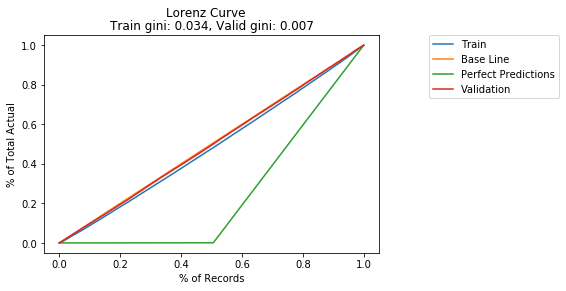

In [25]:
print(mpf.best_threshold(train_wr['team_100_win'], train_pred))
print(mpf.best_threshold(valid_wr['team_100_win'], valid_pred))
mpf.lorenz_curve(train_wr['team_100_win'], train_pred, valid_wr['team_100_win'], valid_pred)

### Lesson 2: Win rates are leaking information about match outcomes

# A Journey of Different Models
#### 1. Encoding paired win rates and head to head win rates
#### 2. The above but with variable selection
#### 3. Word2Vec Encoding
#### 4. Non-positional hot encoding
#### 5. Predicting based on a single team
#### 6. Ensembles

In [ ]:
# Paired win rates with GBM

In [ ]:
# Paired win rates with NN

In [ ]:
# Word2Vec Description

In [ ]:
# Non-positional hot encoding

In [ ]:
# Predicting based on a single team

### Lessons Learned So Far
1. Hot encoding is tough on my laptop
2. Need to find a better way to encode the variables
3. Goal is 56% accuracy
4. Precision and Recall not very important since so balanced.

In [31]:
# Basic Logistic model
formula = 'team_100_win ~ C(RED_TOP_SOLO) + C(RED_MIDDLE_SOLO) + C(RED_JUNGLE_NONE) + C(RED_BOTTOM_DUO_CARRY) + C(BLUE_BOTTOM_DUO_SUPPORT)'
basic_logistic = smf.glm(formula=formula, data=train, family=sm.families.Binomial()).fit()
basic_logistic.summary()

ModuleNotFoundError: No module named 'xgboost'

In [32]:
train_pred.to_csv('../data/model_performance/logistic_blue_side_train_pred.csv', index=False)

In [33]:
valid2_pred.to_csv('../data/model_performance/logistic_blue_side_valid_pred.csv', index=False)

In [ ]:
import importlib
importlib.reload(mpf)

